<a href="https://www.kaggle.com/code/aisuko/audio-classification-with-hubert?scriptVersionId=163504906" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we will walk through the process of using a pre-trained audio transformers for audio classification tasks. We will fine-tuned a transformer model to perform **music genre classification**, where our model receives a music recording as input and labels it as geners like pop or rock.

Before we starting, let's learn what these files actaully contain, and how to work with them. Some terms like:

* waveform
* sampling rate
* spectrogram

Note: It is important to ensure that all audio examples in the dataset have the same sampling rate when working on any audio task. And the sampling rate of the data should match the sampling rate of the data the model was pre-trained on if not we need to do the **resampling** process.

The **sampling rate** determines the time interval between successive audio samples, which impacts the temporal resolution of the audio data. For example, a 5-second sound at a sampling rate of 16,000 Hz will be represented as a series of 80,000 values.

The **amplitude** of a sound describes the sound pressure level at any given instant and is measured in decibels(dB). Teh **bit depth** of the sample determines with how much precision this amplitude value can be described.


# Audio as a waveform

We can plot the sample values over time and illustrates the chnages in the sound's amplitude. This is also known as the `time domain` representation of sound. This type of visualization is useful for identifying specific features of the audio signal such as the timing of individual sound events, the overall loudness of the signal, and any irregularities or noise present in the audio.

In [1]:
%%capture
!pip install librosa==0.10.1

In [2]:
import librosa

array, sampling_rate = librosa.load(librosa.ex('trumpet'))

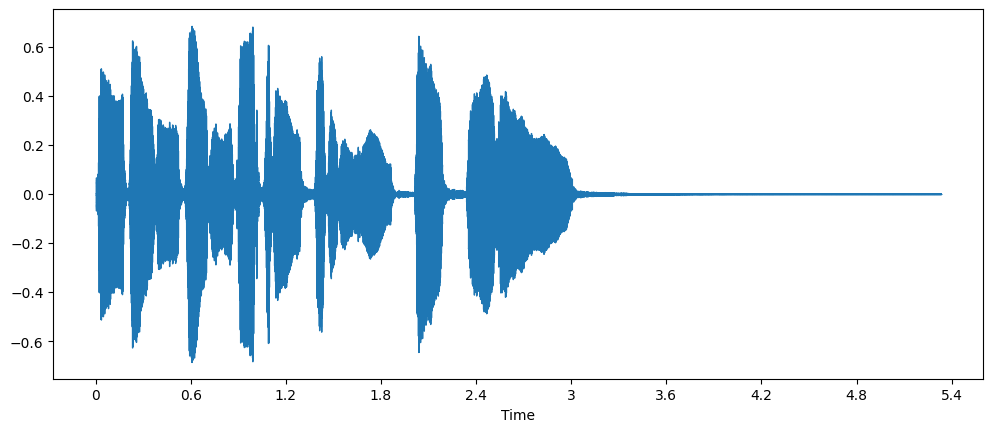

In [3]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

This plots the amplitude of the signal on the y-axis and time along the x-axis. In other words, each point corresponds to a single sample value that was taken when this sound was sampled. Also note that librosa returns the audio as floating-point values already, and that the amplitude values are indeed within the [-1.0, 1.0] range.


# The frequency spectrum

Another way to visualize audio data is to plot the `frequency spectrum` of an audio signal, also known as the `frequency domain` representation. The spectrum is computed using the discrete Fourier transform or DFT. It describes the individual frequencies that make up the signal and how strong they are.

Here, we are going to plot the frequency spectrum for the same trumpet sound by taking the DFT using numpy's `rfft()` function. While it is possible to plot the spectrum of the entire sound, it's more useful to look at a small region instead. Here we will take the DFT over the first 4096 samples, which is roughly the length of the first note being played:

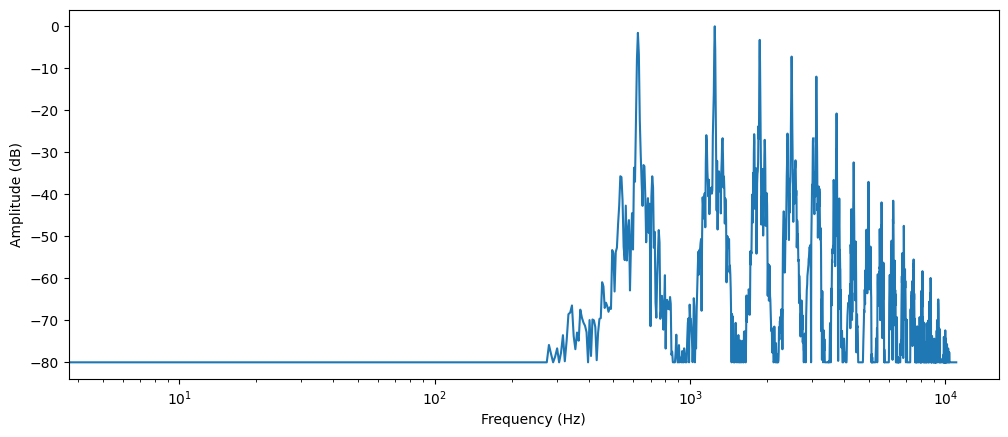

In [4]:
import numpy as np

dft_input=array[:4096]

# calculate the DFT
window =np.hanning(len(dft_input))
windowed_input=dft_input*window
dft=np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude=np.abs(dft)
amplitude_db=librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency=librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.xscale('log')

This plots the strength of the various frequency components that are present in this audio segment. The frequency values are on the x-axis, usually plotted on a logarithmic scale, while their amplitudes are on the y-axis. The frequency spectrum that we plotted shows several peaks. These speaks correspond to the harmonics of the note that's being played, with the higher harmoics being quieter.


# Spectrogram

The waveform plots the amplitude of the audio signal over time, the spectrum visualizes the amplitudes of the individual frequencies at a fixed point in time. What if we want to see how the frequencies in an audio signal change? The problem is that the spectrum only shows a frozen snapshot of the frequencies at a given instant. The solution is to take multiple DFTs, each covering only a small slice of time, and stack the resulting spectra together into a `spectrogram`. The algorithm that performs this computation is the STFT of Short Fourier Transform.

Let's plt a spectrogram for the same trumpet sound.

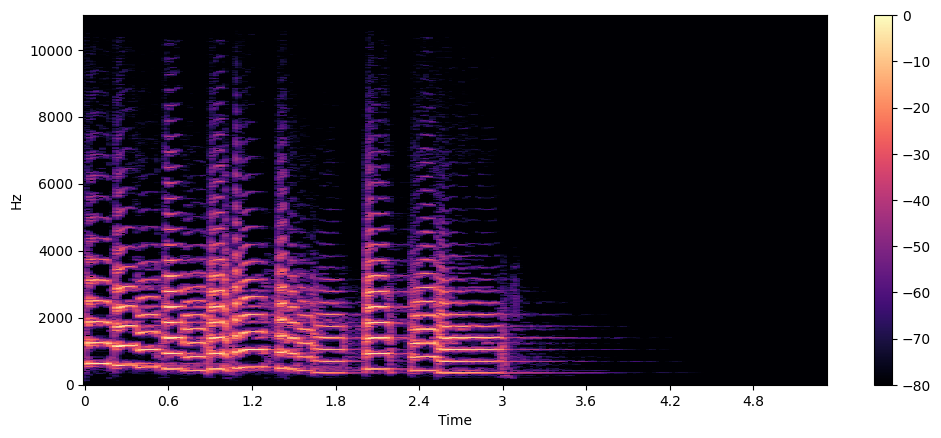

In [5]:
import numpy as np

D=librosa.stft(array)
S_db=librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis='time', y_axis='hz')
plt.colorbar()

In this plot, the x-axis represents time as in the waveform visualization bu now the y-axis represents frequency in Hz. The intensity of the color gives the amplitude of power of the frequency component at each point in time, measured in decibels(dB). The spectrogram is created by taking shot segments of the audio signal, typically lasting a few milliseconds, and calculating the discrete Fourier transform of each segment to obtain its frequency spectrum. The resulting spectra are then stacked together on the time axis to create the spectrogram. Each vertical slice in this image corresponds to a single frequency spectrum, seen from the top. By default, `librosa.stft()` splits the audio signal into segments of 2048 samples, which gives a good-trade-off between frequency resolution and time resolution.

Since the spectrogram and the waveform are different views of the same data, it's possible to turn the spectrogram back into the original waveform using the inverse STFT. In that case, we can use a phase reconstruction algorithm such as the classic Griffin-Lim algorithm, or using a neural network called a vector, to reconstruct a waveform from the spectrogram.


## Mel spectrogram

A mel spectrogram is a variation of the spectrogram that is commonly used in speech processing and machine learning tasks. It is similar to a spectrogram in that it shoes the frequency content of an audio signal over time, but on a different frequency axis.

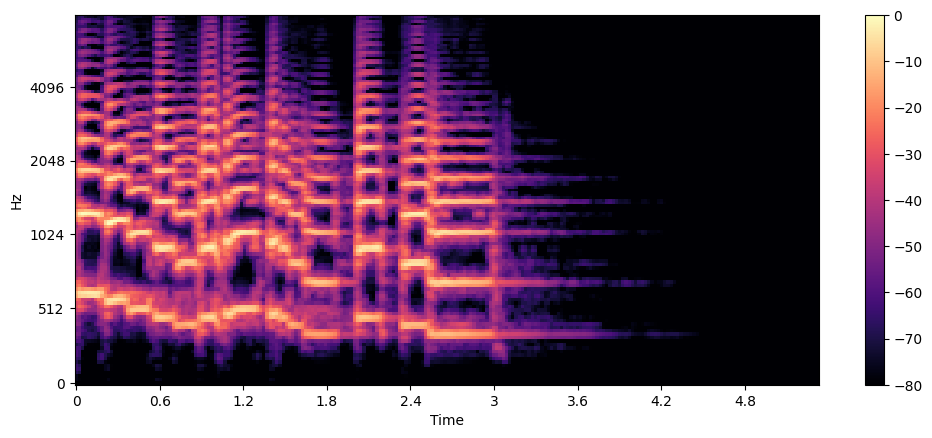

In [6]:
S=librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB=librosa.power_to_db(S,ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000)
plt.colorbar()

In the example above, `n_mel` stands for the number of mel bands to generate. The mel bands define a set of frequency ranges that divide the spectrum into preceptually meaninggul components, using a set of filters whose shape and spacing are chosen to mimic the way the human eart responds to differnt frequencies. Common values for `n_mels` are 40 or 80 `fmax` indicates the highest frequency(in Hz) we care about.


# Introducing the model

Even though the original Transformer architecture was designed to work with text data, we already have many architectures designed to work with audio data. These models may differ on the type of audio data they take as input and the nuances inside theur functioning. Overall, however, they tend to follow a verry similar appraoch to that of the original Transformer.

![](https://cdn.masto.host/sigmoidsocial/media_attachments/files/111/949/616/670/744/384/original/2449efb5c715d2e3.webp)

Here we are going to use [HuBERT](https://arxiv.org/pdf/2106.07447.pdf), is an `encoder-only` model that **is ideal for the task of audio classification. The main idea is to `mask` certain parts of the input audio, and the model is trained to learn how to repdict these masked segments.** It also uses `cluster ensembles` to gerneate pseudo labels that help in guiding the learning process in predicting the masked parts.


# The Dataset

We are going to use the [GTZAN](https://huggingface.co/datasets/marsyas/gtzan) dataset which contains over 500 samples of 30-seconds long audio files consisting of music from several genres.

In [7]:
%%capture --no-stderr
!pip install transformers==4.37.2
!pip install datasets==2.17.0
!pip install evaluate==0.4.1

In [8]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ['DATASET']='marsyas/gtzan'
os.environ['MODEL']='ntu-spml/distilhubert'

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tuning HuBERT"
os.environ["WANDB_NOTES"] = "Fine-tuning HuBERT on gtzan"
os.environ["WANDB_NAME"] = "ft-hubert-on-gtzan"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Loading the data

In [9]:
from datasets import load_dataset

dataset=load_dataset(os.getenv('DATASET'))
dataset

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1454: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [10]:
# shuffle : we ensure the samples are split into training and test randomly
# test_size=.2 : we ensure to use 80% of the data for training 20% of it for validation
dataset=dataset['train'].train_test_split(seed=42, shuffle=True, test_size=.2)
print(dataset['train'][2])

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/disco/disco.00088.wav', 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/disco/disco.00088.wav', 'array': array([ 0.03372192,  0.05703735,  0.06817627, ..., -0.00717163,
        0.00860596,  0.02481079]), 'sampling_rate': 22050}, 'genre': 3}


We can see that the audio files are represented as 1-dimensional arrays, where the value of the array represents the `amplitude` at that particular timestep. And this particular song has a sampling rate of 22050 Hz. We will confirm later on if all files are within that same sampling rate or not.

In [11]:
# Obtaining human-readable label
id2label_function=dataset['train'].features['genre'].int2str
print('genre: ', id2label_function(dataset['train'][2]['genre']))

genre:  disco


In [12]:
# Let's investigate if all sampling rates is the same across the dataset
sampling_rate_check=None
all_same=True

#Iterating through each sample
for set_name in ['train', 'test']:
    for sample in dataset[set_name]:
        sampling_rate=sample['audio']['sampling_rate']
        
        if sampling_rate_check is None:
            sampling_rate_check=sampling_rate
        else:
            if sampling_rate !=sampling_rate_check:
                all_same=False
            break

# Printing result
if all_same:
    print(f'All samples have the same sampling rate')
else:
    print('The samples in the dataset have different sampling rates')

All samples have the same sampling rate


In [13]:
# let's now count the labels
import plotly.express as px

paper_color='#f5f7f6'
bg_color='#f5f7f6'
colormap='cividis'

labels={} # Initlializing empty list

# defining a function to count labels
def count_genres(dataset):
    for sample in dataset:
        genre_label=id2label_function(sample['genre'])
        
        if genre_label in labels:
            labels[genre_label]+=1
        else:
            labels[genre_label]=1

# Counting labels in both sets
count_genres(dataset['train'])
count_genres(dataset['test'])

# obtaining genres and count values
genres=list(labels.keys())
counts=list(labels.values())

# Plotting bar plot
fig=px.bar(x=genres, y=counts, text=counts)
fig.update_traces(marker=dict(color='#4682B4'))
fig.update_layout(title='<b>Genre Counts</b>', 
                  showlegend=True, 
                  height=500, 
                  width=750, 
                  plot_bgcolor=bg_color, 
                  paper_bgcolor=paper_color)
fig.update_yaxes(title_text='<b>Count</b>')
fig.update_xaxes(title='<b>Genres</b>')

fig.show()

# Exploratory Data Analysis

Jazz is the only genre wit only 99 samples, this is due to a corrupted file that was removed from the dataset. Let's see our data by using `librosa`. Let's see the different music genre from the examples.

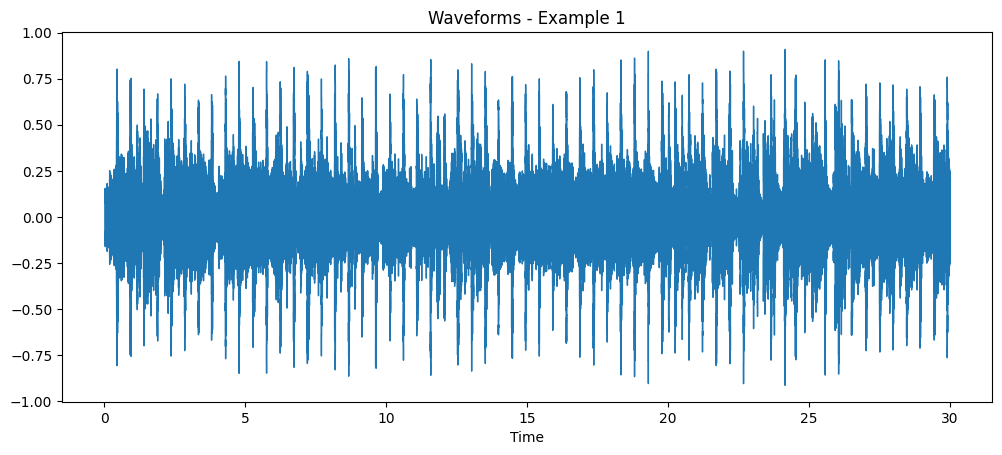

In [14]:
array=dataset['train'][2]['audio']['array']
sampling_rate=dataset['train'][2]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - Example 1')
librosa.display.waveshow(array, sr=sampling_rate)
plt.show()

In [15]:
from IPython.display import Audio


# Displaying audio file
Audio(data=array, rate=sampling_rate)

In [16]:
# Printing genre
print('genre: ', id2label_function(dataset['train'][2]['genre']))

genre:  disco


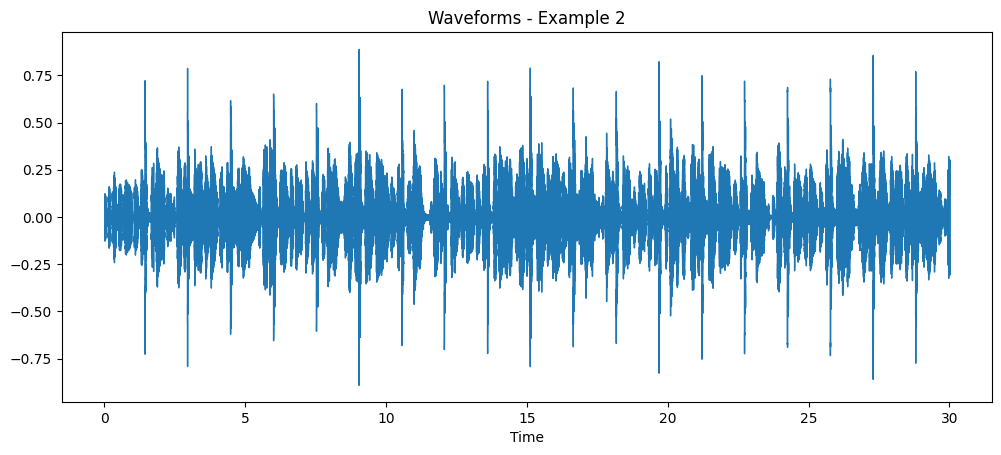

In [17]:
array=dataset['train'][14]['audio']['array']
sampling_rate=dataset['train'][14]['audio']['sampling_rate']

plt.figure().set_figwidth(12)
plt.title('Waveforms - Example 2')
librosa.display.waveshow(array,sr=sampling_rate)
plt.show()

In [18]:
Audio(data=array, rate=sampling_rate)

In [19]:
print('genre: ', id2label_function(dataset['train'][14]['genre']))

genre:  reggae


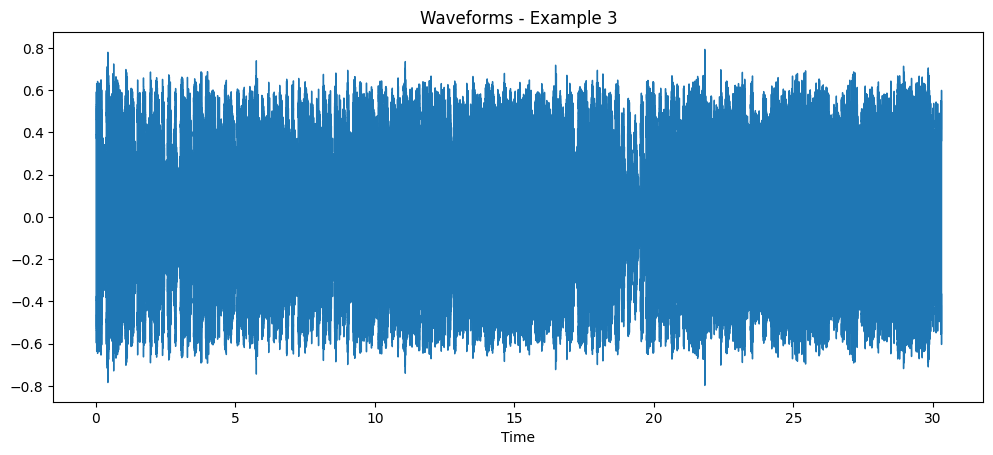

In [20]:
array=dataset['train'][42]['audio']['array']
sampling_rate=dataset['train'][42]['audio']['sampling_rate']

plt.figure().set_figwidth(12)

plt.title('Waveforms - Example 3')
librosa.display.waveshow(array, sr=sampling_rate)
plt.show()

In [21]:
Audio(data=array, rate=sampling_rate)

In [22]:
print('genre: ', id2label_function(dataset['train'][42]['genre']))

genre:  rock


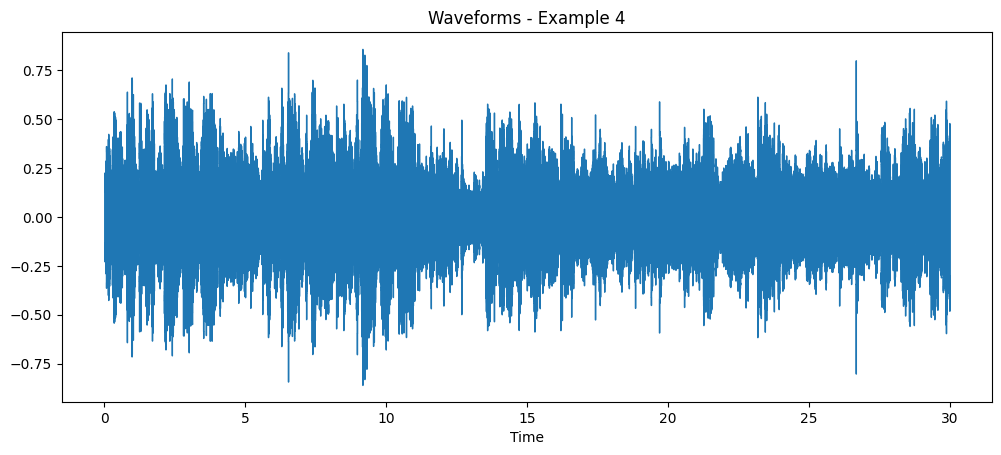

In [23]:
array=dataset['train'][212]['audio']['array']
sampling_rate=dataset['train'][212]['audio']['sampling_rate']

plt.figure().set_figwidth(12)

plt.title('Waveforms - Example 4')
librosa.display.waveshow(array, sr=sampling_rate)
plt.show()

Right above, we have three auio files from different genres: `disco`, `reggae`, `rock`.


## Preprocessing the data

Similar to the tokenization process in NLP, audio models require the input to be encoded in a format that the model can understand. Here we are going to `AutoFeatureExtractor` that is efficient in selecting the correct feature extractor of any given model.

In [24]:
from transformers import AutoFeatureExtractor

feature_extractor=AutoFeatureExtractor.from_pretrained(os.getenv('MODEL'), do_normalize=True, return_attention_mask=True)

# Checking sampling rate
sampling_rate=feature_extractor.sampling_rate
print(f'DistilHuBERT Sampling Rate: {sampling_rate} Hz')

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

DistilHuBERT Sampling Rate: 16000 Hz


In [25]:
# Define audio maximum duration
max_duration=30.0

def preprocess_function(examples):
    # extracting and saving arrays
    audio_arrays=[x['array'] for x in examples['audio']]
    
    # preprocessing audio inputs
    inputs=feature_extractor(audio_arrays, sampling_rate=sampling_rate, max_length=int(sampling_rate*max_duration), truncation=True, return_attention_mask=True)
    return inputs

dataset_encoded=dataset.map(preprocess_function, remove_columns=['audio', 'file'], batched=True, batch_size=100, num_proc=1)
dataset_encoded

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

2024-02-20 03:09:52.894933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 03:09:52.895070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 03:09:53.071420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 799
    })
    test: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 200
    })
})

To enable the `Trainer` class to process labels, we must rename this column to `label`.

In [26]:
# renaming genre column
dataset_encoded=dataset_encoded.rename_column('genre', 'label')
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 799
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 200
    })
})

Mapping our genre labels from integer IDs to human-readable descriptions and vice-versa.

In [27]:
id2label={str(i): id2label_function(i) for i in range(len(dataset_encoded['train'].features['label'].names))}

# Label to id
label2id={v:k for k, v in id2label.items()}
print(label2id)

{'blues': '0', 'classical': '1', 'country': '2', 'disco': '3', 'hiphop': '4', 'jazz': '5', 'metal': '6', 'pop': '7', 'reggae': '8', 'rock': '9'}


# Training

In [28]:
from transformers import AutoModelForAudioClassification

num_labels=len(id2label)

model=AutoModelForAudioClassification.from_pretrained(os.getenv('MODEL'),num_labels=num_labels, label2id=label2id, id2label=id2label)
model

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(

In [29]:
import evaluate
import numpy as np

metric=evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions=np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [30]:
from transformers import TrainingArguments, Trainer

training_args=TrainingArguments(
    output_dir=os.getenv('WANDB_NAME'),
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=5e-5,
    seed=42,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    max_steps=100, # We control the total training steps to fit the limied resources
    num_train_epochs=2,
    warmup_ratio=0.1,
    fp16=True,
    save_total_limit=2,
    report_to='wandb',
    run_name=os.getenv('WANDB_NAME')
)

trainer=Trainer(model=model, args=training_args, train_dataset=dataset_encoded['train'], eval_dataset=dataset_encoded['test'], tokenizer=feature_extractor, compute_metrics=compute_metrics)

trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240220_031045-n8ywwzh8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-hubert-on-gtzan
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tuning%20HuBERT
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tuning%20HuBERT/runs/n8ywwzh8
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



TrainOutput(global_step=100, training_loss=2.0346534729003904, metrics={'train_runtime': 1693.7132, 'train_samples_per_second': 0.945, 'train_steps_per_second': 0.059, 'total_flos': 1.0903351794048e+17, 'train_loss': 2.0346534729003904, 'epoch': 2.0})

In [31]:
kwargs={
    'dataset_tags': f'{os.getenv("DATASET")}',
    'dataset': 'GTZAN',
    'model_name': f'{os.getenv("WANDB_NAME")}',
    'finetuned_from': f'{os.getenv("MODEL")}',
    'tasks': 'audio-classification'
}

trainer.push_to_hub(**kwargs)
feature_extractor.push_to_hub(os.getenv('WANDB_NAME'))

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aisuko/ft-hubert-on-gtzan/commit/57df014623412ed689afa38cae81ea102539da26', commit_message='Upload feature extractor', commit_description='', oid='57df014623412ed689afa38cae81ea102539da26', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [32]:
from transformers import pipeline

pipe=pipeline(kwargs['tasks'], model=f'aisuko/{os.getenv("WANDB_NAME")}')
pipe("https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/1.flac")

config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

[{'score': 0.12185443192720413, 'label': 'hiphop'},
 {'score': 0.11919249594211578, 'label': 'reggae'},
 {'score': 0.10803275555372238, 'label': 'pop'},
 {'score': 0.1037718653678894, 'label': 'country'},
 {'score': 0.10054106265306473, 'label': 'blues'}]

# Reference

* https://huggingface.co/learn/audio-course/chapter4/fine-tuning#share-model
* https://medium.com/ai-in-plain-english/audio-data-music-genre-classification-8fe58cc9444e